# Leoilab - Deep learning workshop - Techfestival 2018


This workshop will take you through training of a deep neural network using Keras. 

We will train a network to diagnose malignant vs benign melanoma.

We'll cover the following topics:
* Loading data
* Training a basic network
* Transfer learning
* Adding data augmentation

## Basics of Jupyter Notebooks

Cell types:
* Markdown cells: Cells like this one with markdown-text in it
     - Change highlighted cell to markdown with: `m`
* Code cells: Python code cells.
    - Change highlighted cell to code with: `y`

When highlighting cell:
* `shift + enter`: Run cell
* `enter`: Enter edit mode in cell
* `esc`: Exit edit mode in cell

From header above:
* `Kernel > Interrupt`: Stop long running cell ( you might need this if running too many epochs ).
* `Kernel > Restart`: Restart entire notebook, if it really messes up do this and re-run relevant cells.

In [1]:
## These are some helper functions to plot the outputs of our models

def plot_training_epochs(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.epoch, history.history['acc'])
    plt.plot(history.epoch, history.history['val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    l = plt.legend(['training accuracy', 'validation accuracy'])

def plot_images_with_label(images, labels, class_):
    img_to_plot = images[labels[:, class_]==1, ...]

    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    for ax, img in zip(axes, img_to_plot):
        ax.imshow(array_to_img(img))
        ax.axis('off')
        
def print_confusion_matrix(y_true, y_hat):
    return pd.DataFrame(confusion_matrix(y_true, y_hat),
                        index=['true_' + cls for cls in classes],
                        columns=['pred_' + cls for cls in classes])

def rand_by_mask(mask, n=4):
    return np.random.choice(np.where(mask)[0], n, replace=False)

def rand_by_correct(is_correct, y_true, y_hat, n=4):
    return rand_by_mask((y_true == y_hat) == is_correct, n=n)

def plot_image_ids(image_ids, generator):
    images = np.array(generator.filenames)[image_ids]
    print("True classes: %s" % ' '.join(img.split('/')[0] for img in images))
    fig, axes = plt.subplots(1, len(images), figsize=(15, 10))
    for ax, img in zip(axes, images):
        image = load_img(path_to_data + '/valid/' + img)
        ax.imshow(image)
        ax.axis('off')

def plot_correct_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(True, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(classes[i] for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)

def plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(False, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(classes[i] for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)


## Loading data

First thing you need to do is load the data. In the following you can choose:

* cat vs dog data: This is nice to use for beginners because it is easy to inspect what happens in each step
* ISIC melanoma data: This is harder to classify, and unless you're a dermatologist it's hard to tell the classes apart. But maybe you can get the computer do so?

In [2]:
cats_and_dogs_data = '/home/ubuntu/store/dogscats/1ksample'
melanoma_data = '/home/ubuntu/store/isic/1ksample'

# Change this to "cats_and_dogs_data" to use that dataset instead.
path_to_data = cats_and_dogs_data

In [3]:
# Load some of the things we need from keras
from keras.preprocessing.image import ImageDataGenerator          # generator to cycle through images
from keras.preprocessing.image import array_to_img                # function to convert arrays back to images 
from keras.applications.imagenet_utils import preprocess_input    # normalization function for ImageNet
from keras.preprocessing.image import load_img                    # function to load image

import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
## Set up some global variables
# Batch size is how many images the network looks at at a time
batch_size = 16

# The image size is what we should scale the images to
image_size = (224, 224)

# This is the number of classes to classify.
#    This is important for what the output of the network should look like.
#    In both cases we have two classes (dog/cat) (malignant/benign)
n_classes = 2

In [5]:
## Create data generators
# Create a generator that runs `preprocess_input` on every loaded image.
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the training and validation generators.
# They use the image sizes, batch sizes, and paths to data set above.
print('Load training.')
train_gen = data_generator.flow_from_directory(path_to_data + '/train',
                                               batch_size=batch_size,
                                               target_size=image_size)
print('\nLoad validation.')
valid_gen = data_generator.flow_from_directory(path_to_data + '/valid',
                                               batch_size=batch_size,
                                               target_size=image_size,
                                               shuffle=False)

# Create a list of classes sorted by index
classes = [cls[0] for cls in sorted(train_gen.class_indices.items(), key=lambda e: e[1])]

Load training.
Found 2125 images belonging to 2 classes.

Load validation.
Found 2000 images belonging to 2 classes.


The generators `train_gen` and `test_gen` will iterate over training and testing images. 

Each output will be a tuple of image-tensor and label-vector.

Try plotting the first image:

In [6]:
images, labels = next(train_gen)

Images here contains a tensor with shape:

`(batch_size, image_height, image_width, image_channels)`

In our case that is:

In [7]:
images.shape

(16, 224, 224, 3)

The output of labels is a one-hot encoding of the class

The dictionary of the class can be seen in:

In [8]:
train_gen.class_indices

{'cats': 0, 'dogs': 1}

In [9]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

The helper function:

`plot_images(images, labels, class)`

can plot the images from one of the classes (given the labels). Try plotting both classes here:

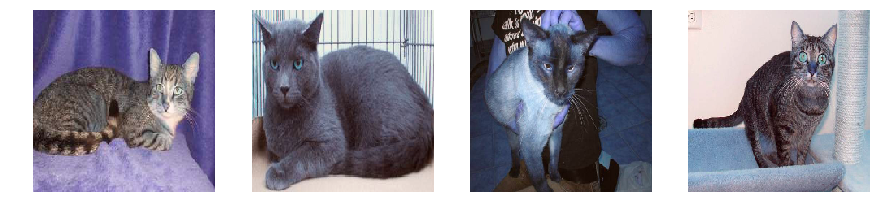

In [10]:
plot_images_with_label(images, labels, 0)

## Train a basic network

Keras has multiple predefined networks that work well for different tasks under `keras.applications`.

They are normally designed to perform on the 1000-class [ImageNet](https://www.image-net.org/) dataset.

In our case we only have benign / malignant (or cats vs. dogs), so we need to specify that we want the networks with two instead of a thousand outputs.

In [11]:
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam

# Create the resnet model
model = ResNet50(classes=2, weights=None)

# Compile model - don't worry about this :)
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

The model we loaded here has `weights=None`, with this we will randomly initialize the weights of the model.

Keras models have methods for doing a bunch of the basic things we might want to do. 

The resnet model is very big:

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

To train the model you can run `model.fit_generator`

Every time the model has trained once on the training data it will evaluate it's accuracy on the validation data. The resulting training and validation accuracies are printed.

When you're done running this you can plot them. 

Try increasing the number of epochs to run - can you get it to train?

In [13]:
history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=2
)

Epoch 1/2
133/133 [==============================] - 112s 842ms/step - loss: 1.0606 - acc: 0.5503 - val_loss: 0.8501 - val_acc: 0.5630
Epoch 2/2
133/133 [==============================] - 94s 708ms/step - loss: 0.7057 - acc: 0.6100 - val_loss: 0.6886 - val_acc: 0.5775


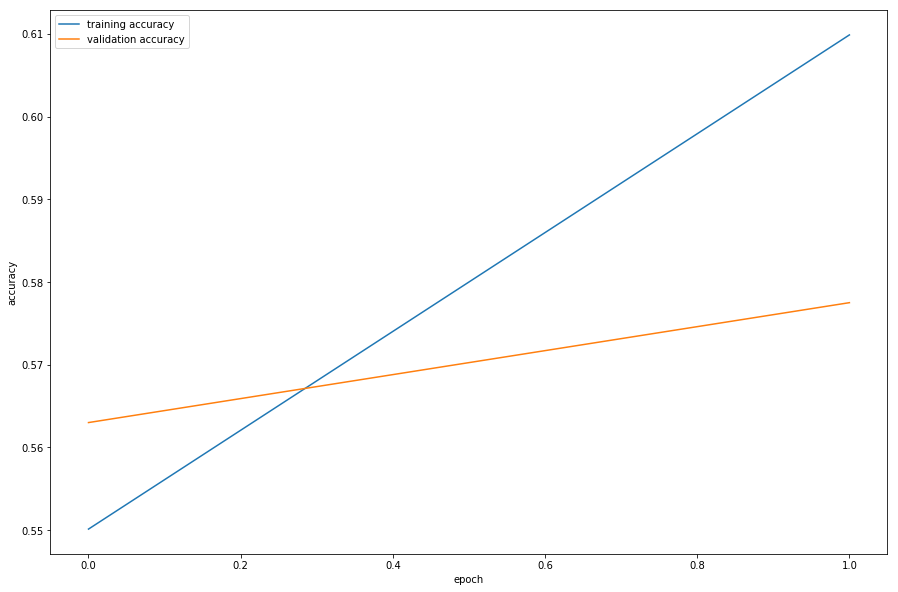

In [14]:
plot_training_epochs(history)

The first thing we want to do, when having trained a network is look at performance. We can see how the network does during training above. The orange line is the validation accuracy after each epoch.

But let's try and inspect the resulting predictions.

We use a confusion matrix, first:

In [15]:
# Get some metrics for evaluating the notebook
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

125/125 [==============================] - 20s 162ms/step


In [16]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat)

Accuracy: 0.5775
Confusion matrix:


,pred_cats,pred_dogs
true_cats,930,70
true_dogs,775,225


You can also plot random examples of correctly and incorrectly classified images using the cells below.

As they are randomized you can see more examples by rerunning the cells.

Is there a pattern to the incorrectly classified examples?

Predictions: cats cats dogs dogs
True classes: dogs dogs cats cats


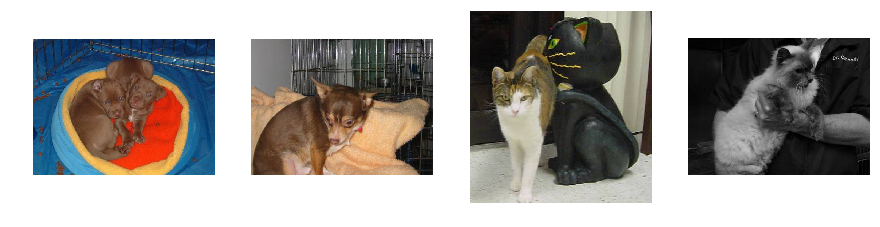

In [71]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

Predictions: dogs cats dogs dogs
True classes: dogs cats dogs dogs


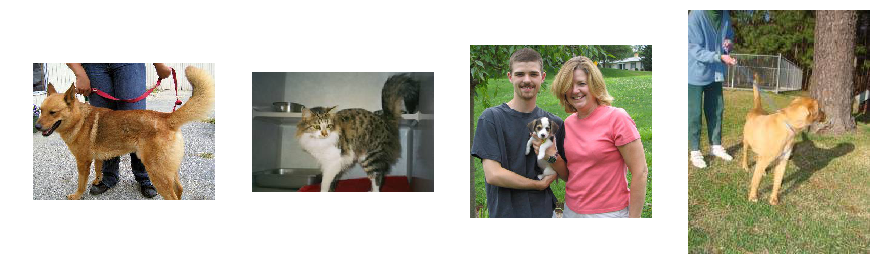

In [20]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)

Even after a bunch of epochs, the model doesn't really get any better. This might be due to the relatively small data set we're using here.

## Transfer learning

In transfer learning we take a model that was initially trained on one task and use it for another task.

All models in `keras.applications` are pre-trained on the 1000 classes in ImageNet, with _a lot_ of data for each class. This means that they can learn the low level representations of objects, and we just need to 

In [22]:
from keras.layers import Dense
from keras.models import Model
from keras.layers import BatchNormalization

# Load the ResNet model - now with pretrained imagenet weights
model_imagenet = ResNet50(weights='imagenet')

# Create an output layer with two classes instead of 1000. 
# The input to that layer should be the second to last layer of the imagenet model.
output_layer = Dense(n_classes, activation='softmax')(model_imagenet.layers[-2].output)

# Now we can build a new model with our self-defined activation output:
model = Model(inputs=model_imagenet.input, outputs=output_layer)

This new model will have all layers trainable. We only want to train the layer we added to the top of the model.

You can set a layer to be trainable like this:

In [23]:
output_layer.trainable = True

If set to `False` it will be untrainable.

Set all layers in model to not train, except the output layer:

In [24]:
for layer in model_imagenet.layers[:-1]:
    if isinstance(layer, BatchNormalization):
        continue
    layer.trainable = False

Now we can compile the model.

In [25]:
# Compile model - don't worry about this :)
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

Now try fitting the generator as above.

In [26]:
history = model.fit_generator(train_gen,
                              validation_data=valid_gen,
                              epochs=2,
                              )

Epoch 1/2
133/133 [==============================] - 85s 637ms/step - loss: 0.1819 - acc: 0.9234 - val_loss: 0.0905 - val_acc: 0.9640
Epoch 2/2
133/133 [==============================] - 76s 569ms/step - loss: 0.0694 - acc: 0.9745 - val_loss: 0.0523 - val_acc: 0.9820


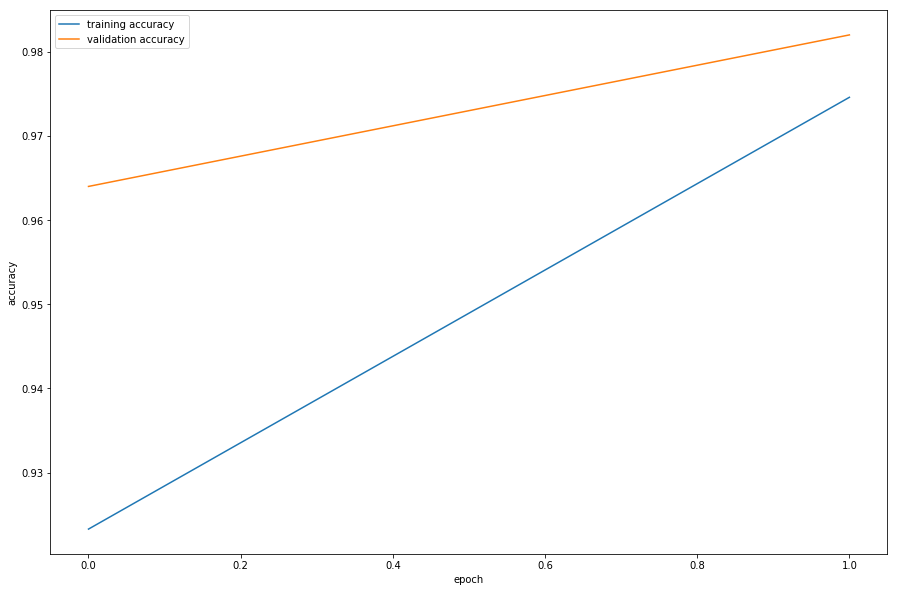

In [27]:
plot_training_epochs(history)

We can inspect results similar to above.

Are there any new learnings from the incorrect/correct examples?

Try training for longer - how does the train/valid accuracy change?

In [28]:
y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

125/125 [==============================] - 21s 167ms/step


In [29]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat)

Accuracy: 0.9820
Confusion matrix:


,pred_cats,pred_dogs
true_cats,977,23
true_dogs,13,987


Predictions: dogs cats dogs dogs
True classes: cats dogs cats cats


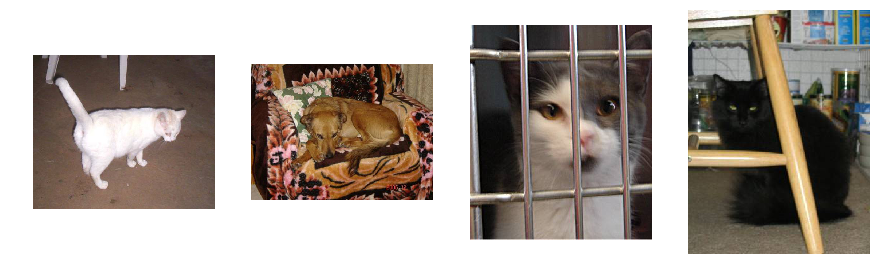

In [34]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

Predictions: dogs cats dogs cats
True classes: dogs cats dogs cats


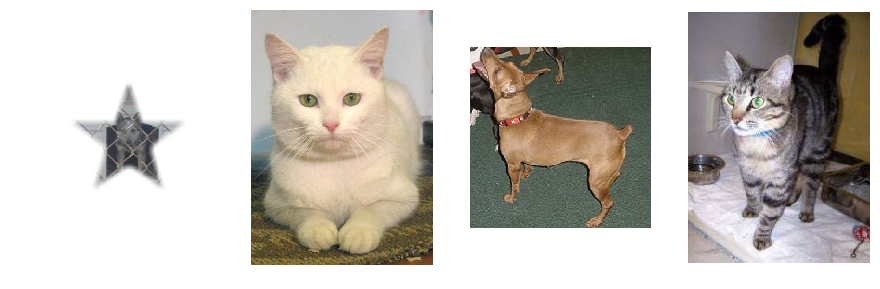

In [37]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)

## Data augmentation

We see a much better training accuracy then before, but we can also see a bit of overfitting. This is because - when training on the same data multiple times - the model will learn to just remember the data that was shown previously.

Since images are very dense with information it is quite easy for this big of a model to remember patterns in each of the images in our data set. To force the model to generalize we can use data augmentation.

Data augmentation adds a small random transformation to an image everytime it's loaded (once per epoch).

The augmentations we use here are flips, rotations, and zoom.

This sure that the model never sees the __exact__ same image twice.

Data augmentation is very easy to add in the `ImageDataGenerator` in keras:

In [38]:
# Specify how much data augmentation we want on the images.
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40.0, # degrees of rotation
    zoom_range=0.3
)

train_gen = data_generator.flow_from_directory(path_to_data + '/train', batch_size=batch_size, target_size=image_size)
valid_gen = data_generator.flow_from_directory(path_to_data + '/valid',
                                               batch_size=batch_size,
                                               target_size=image_size,
                                               shuffle=False)

Found 2125 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Now let's have a look at how the augmented images look:

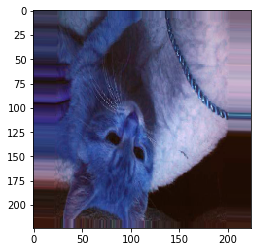

In [39]:
imgs, labs = next(train_gen)
plt.imshow(array_to_img(imgs[0, ...]))

Now try training the model again. You can let it run for a while. See how many epochs you need to run before getting to overfitting.

In [40]:
history = model.fit_generator(train_gen,
                              validation_data=valid_gen,
                              epochs=15,
                              )

Epoch 1/15
133/133 [==============================] - 88s 661ms/step - loss: 0.2195 - acc: 0.9079 - val_loss: 0.1848 - val_acc: 0.9340
Epoch 2/15
133/133 [==============================] - 86s 645ms/step - loss: 0.1890 - acc: 0.9281 - val_loss: 0.1646 - val_acc: 0.9365
Epoch 3/15
133/133 [==============================] - 85s 641ms/step - loss: 0.1501 - acc: 0.9375 - val_loss: 0.2131 - val_acc: 0.9200
Epoch 4/15
133/133 [==============================] - 87s 655ms/step - loss: 0.1235 - acc: 0.9521 - val_loss: 0.1288 - val_acc: 0.9540
Epoch 5/15
133/133 [==============================] - 87s 654ms/step - loss: 0.1120 - acc: 0.9563 - val_loss: 0.1332 - val_acc: 0.9510
Epoch 6/15
  3/133 [..............................] - ETA: 54s - loss: 0.0635 - acc: 0.9583

KeyboardInterrupt: 

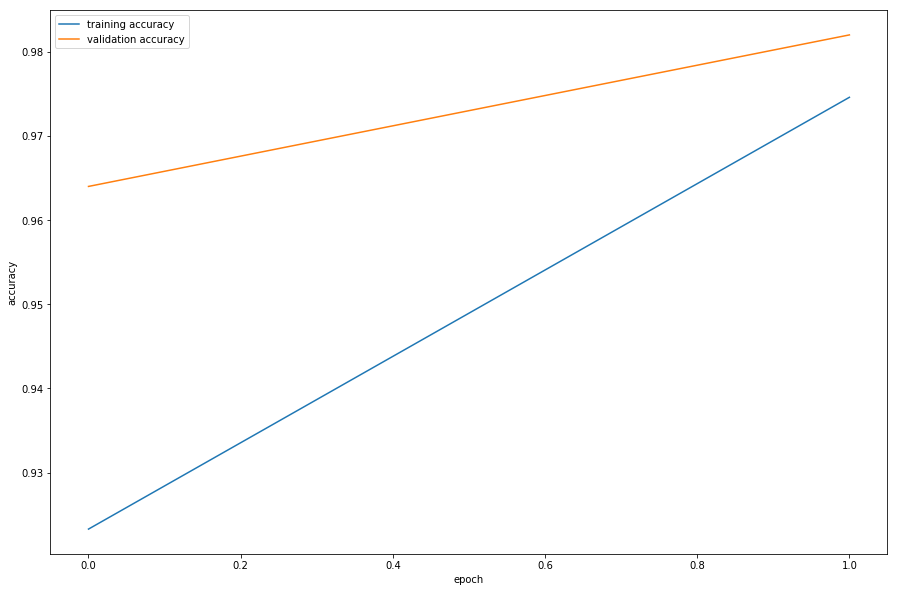

In [41]:
plot_training_epochs(history)

If you want to try increasing the amount of training data, remove `1ksample` from the end of `path_to_data`.

In [42]:
y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

125/125 [==============================] - 32s 256ms/step


In [44]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat)

Accuracy: 0.9425
Confusion matrix:


,pred_cats,pred_dogs
true_cats,912,88
true_dogs,27,973


Predictions: dogs dogs dogs dogs
True classes: cats cats cats cats


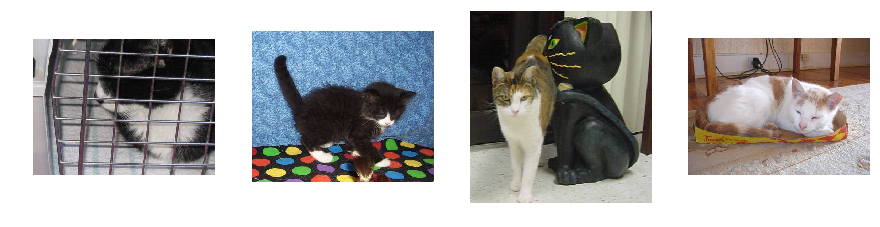

In [64]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

Predictions: cats cats cats dogs
True classes: cats cats cats dogs


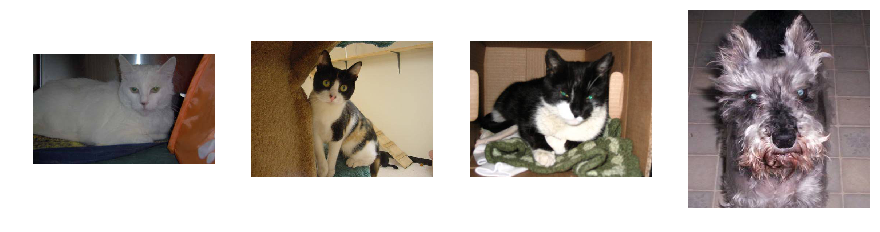

In [69]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)

## Feedback:

Please leave any feedback you migh have in the following text cell - then we'll try to improve our workshop for next time: